In [1]:
import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")

# set working directory to root 
import os
os.chdir("../../")
print(os.getcwd())
root = os.getcwd()

/teamspace/studios/this_studio


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from matplotlib.colors import ListedColormap

from src.models.datamodule import MineDataModule
from src.models.clay.segment.model import MineSegmentor

from src.visualization.visualization_funcs import plot_pred_vs_true_mask

### Define paths and parameters

In [3]:
MINESEG_CHECKPOINT_PATH = (
    "models/clay/mineseg-clay-segment_epoch-00_val-iou-0.3156.ckpt"
)

CLAY_CHECKPOINT_PATH = "models/clay-v1-base.ckpt"
METADATA_PATH = "configs/clay/clay_segment_metadata.yaml"

TRAIN_CHIP_DIR = "data/processed/chips/npy/train/chips/"
TRAIN_LABEL_DIR = " data/processed/chips/npy/train/labels/"
VAL_CHIP_DIR = "data/processed/chips/npy/val/chips/"
VAL_LABEL_DIR = "data/processed/chips/npy/val/labels/"
TEST_CHIP_DIR = "data/processed/chips/npy/test/chips/"
TEST_LABEL_DIR = "data/processed/chips/npy/test/labels/"

BATCH_SIZE = 1
NUM_WORKERS = 1
PLATFORM = "sentinel-2-l2a"

In [4]:
is_lightning = True
if is_lightning:
    root = root + "/workspaces/mine-segmentation"
    MINESEG_CHECKPOINT_PATH = root + "/" + MINESEG_CHECKPOINT_PATH
    CLAY_CHECKPOINT_PATH = root + "/" + CLAY_CHECKPOINT_PATH
    METADATA_PATH = root + "/" + METADATA_PATH
    TRAIN_CHIP_DIR = root +  "/" +TRAIN_CHIP_DIR
    TRAIN_LABEL_DIR = root + "/" + TRAIN_LABEL_DIR
    VAL_CHIP_DIR = root + "/" + VAL_CHIP_DIR
    VAL_LABEL_DIR = root + "/" + VAL_LABEL_DIR
    TEST_CHIP_DIR = root + "/" + TEST_CHIP_DIR
    TEST_LABEL_DIR = root + "/" + TEST_LABEL_DIR
    print(MINESEG_CHECKPOINT_PATH)

/teamspace/studios/this_studio/workspaces/mine-segmentation/models/clay/mineseg-clay-segment_epoch-00_val-iou-0.3156.ckpt


### Model Loading

In [5]:
def get_model(mineseg_checkpoint_path, clay_checkpoint_path, metadata_path):
    model = MineSegmentor.load_from_checkpoint(
        checkpoint_path=mineseg_checkpoint_path,
        metadata_path=metadata_path,
        ckpt_path=clay_checkpoint_path,
    )
    model.eval()
    return model

### Data Preparation

In [6]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    test_chip_dir,
    test_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    data_augmentation,
    index=None
):
    dm = MineDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        test_chip_dir=test_chip_dir,
        test_label_dir=test_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
        data_augmentation=data_augmentation,
    )
    
    dm.setup(stage="test")
    
    if index is not None:
        test_dl = iter(dm.test_dataloader())
        for i in range(index + 1):
            batch = next(test_dl)
        metadata = dm.metadata
        return batch, metadata
    else:
        test_dl = dm.test_dataloader()
        batch = next(iter(test_dl))
        metadata = dm.metadata
        return batch, metadata
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [7]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(512, 512), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [14]:
def post_process(batch, outputs, metadata):
    # normalize outputs into 0-1 range
    probas = outputs.detach().cpu().numpy()
    probas = (probas - probas.min()) / (probas.max() - probas.min())
    probas = np.clip(probas, 0, 1)
    preds = probas > 0.5
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    # normalize and clip the image ranges
    pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())
    pixels = np.clip(pixels, 0, 1)

    images = pixels[0]
    labels = labels[0]
    probas = probas[0][0]
    preds = preds[0][0]

    images = images.transpose((1,2,0))

    return images, labels, probas, preds

### Plotting

In [9]:
def plot_predictions(images, labels, probas, preds):
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))

    # Plot the image
    axes[0].imshow(images)
    axes[0].axis("off")
    axes[0].set_title("Image", fontsize=12)

    # Plot the actual segmentation
    axes[1].imshow(labels, vmin=0, vmax=1)
    axes[1].axis("off")
    axes[1].set_title("Actual", fontsize=12)

    # Plot the predicted segmentation
    axes[2].imshow(preds, vmin=0, vmax=1)
    axes[2].axis("off")
    axes[2].set_title("Pred", fontsize=12)

    # Plot the predicted segmentation
    axes[3].imshow(probas, vmin=0, vmax=1)
    axes[3].axis("off")
    axes[3].set_title("Proba", fontsize=12)

    # Plot the plot_pred_vs_true_mask
    plot_pred_vs_true_mask(images, labels, preds.squeeze(), ax=axes[4], add_legend=False)
    axes[4].set_title("Pred vs True", fontsize=12)

    plt.tight_layout()
    plt.show()

In [10]:
# Load model
model = get_model(MINESEG_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)

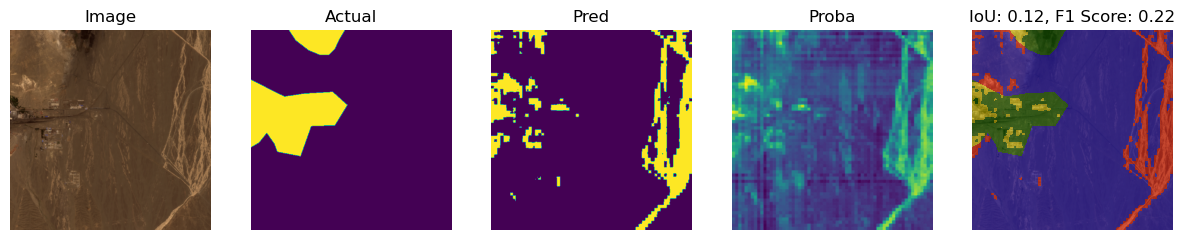

<Figure size 640x480 with 0 Axes>

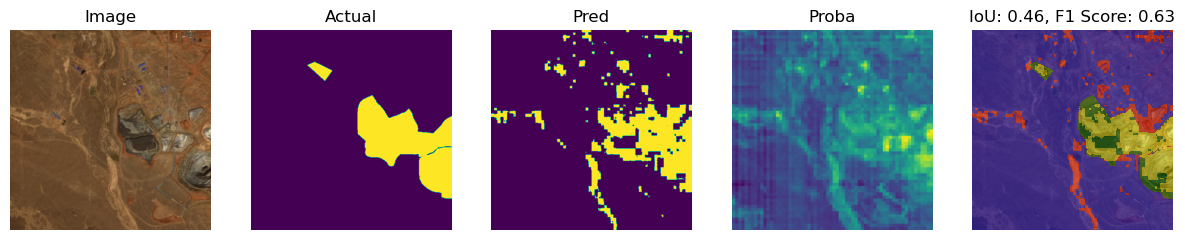

<Figure size 640x480 with 0 Axes>

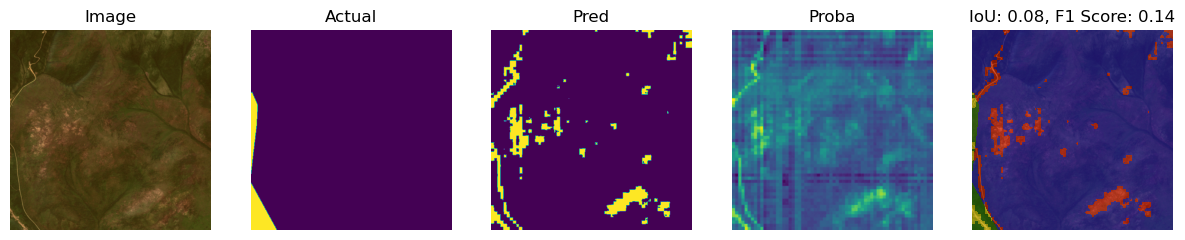

<Figure size 640x480 with 0 Axes>

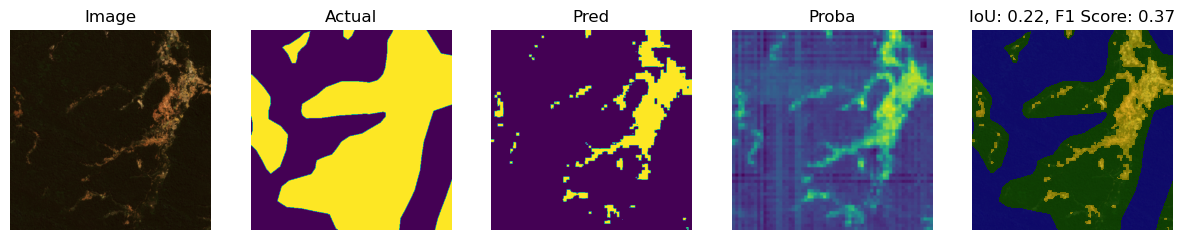

<Figure size 640x480 with 0 Axes>

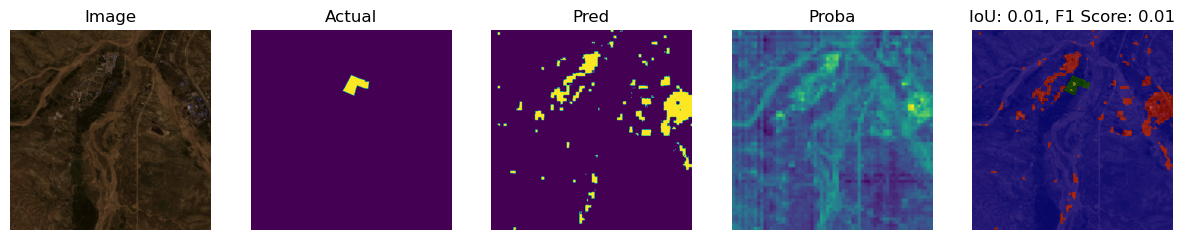

<Figure size 640x480 with 0 Axes>

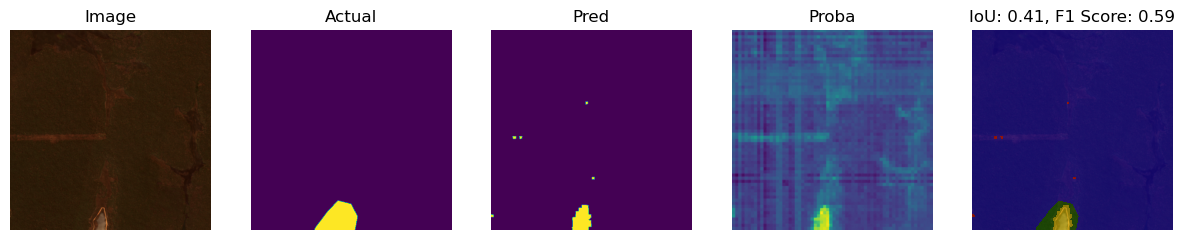

<Figure size 640x480 with 0 Axes>

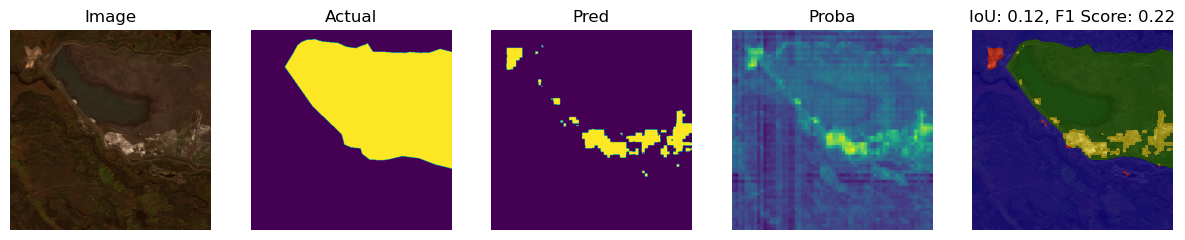

<Figure size 640x480 with 0 Axes>

In [17]:
import random

nr_test_chips = len(os.listdir(TEST_CHIP_DIR))
sample = random.sample(range(nr_test_chips), 7)

for index in sample:

    # Get data
    batch, metadata = get_data(
        TRAIN_CHIP_DIR,
        TRAIN_LABEL_DIR,
        VAL_CHIP_DIR,
        VAL_LABEL_DIR,
        TEST_CHIP_DIR,
        TEST_LABEL_DIR,
        METADATA_PATH,
        BATCH_SIZE,
        NUM_WORKERS,
        PLATFORM,
        data_augmentation=False,
        index=index,
    )

    # Move batch to GPU
    if torch.cuda.is_available():
        batch = {k: v.to("cuda") for k, v in batch.items()}

    # Run prediction
    outputs = run_prediction(model, batch)
    
    # Post-process the results
    images, labels, probas, preds = post_process(batch, outputs, metadata)

    # Plot the predictions
    plot_predictions(images, labels, probas, preds)